# Assignment 3 - Part 1
## Natural Language Processing (CS60075)
### **Hardik Soni** - 20CS30023

In [1]:
! pip install -q accelerate transformers faiss-cpu sentence-transformers tqdm

In [2]:
import re
import os
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas() 
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

import torch
import faiss
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
from transformers import T5Tokenizer, T5ForConditionalGeneration

In [3]:
device = ("cuda" if torch.cuda.is_available() else 
          "mps" if torch.backends.mps.is_available() else "cpu")
device

'cuda'

In [4]:
# Define a cleaning function using regex
def clean_text(text):
    # Remove HTML-like tags (e.g., <tag>)
    text = re.sub(r'<.*?>', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove emojis
    text = re.sub(r'[^\w\s,]', '', text)
    # Remove special characters (only keep letters, numbers, and spaces)
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [5]:
input_path = '/kaggle/input/online-hate-and-offensive-speech-classification/'
train_path = input_path+'data/NLP_ass_train.tsv'
valid_path = input_path+'data/NLP_ass_valid.tsv'
test_path = input_path+'data/NLP_ass_test.tsv'
output_dir = '/kaggle/working/'
col_names = ['post_text', 'sentiment_label']

# Dataset Exploration

In [6]:
train_ds = pd.read_csv(train_path, sep='\t', header=None, names=col_names)
valid_ds = pd.read_csv(valid_path, sep='\t', header=None, names=col_names)
test_ds  = pd.read_csv(test_path, sep='\t', header=None, names=col_names)

# Apply the cleaning function to both train_ds and valid_ds
# train_ds, valid_ds, test_ds = [df.assign(post_text=df['post_text'].astype(str).apply(clean_text)) 
#                                for df in [train_ds, valid_ds, test_ds]]

In [7]:
def count_identical_posts(df1, df2):
    """
    Count the number of identical post_text entries between two DataFrames.
    
    Parameters:
        df1 (pd.DataFrame): First DataFrame containing 'post_text' column.
        df2 (pd.DataFrame): Second DataFrame containing 'post_text' column.
    
    Returns:
        int: Number of identical post_text entries between df1 and df2.
    """
    # Ensure the column 'post_text' exists in both DataFrames
    if 'post_text' not in df1.columns or 'post_text' not in df2.columns:
        raise ValueError("Both DataFrames must contain the 'post_text' column.")
    
    # Find the intersection of post_text entries between the two DataFrames
    identical_posts = df1['post_text'].isin(df2['post_text'])
    
    # Count and return the number of matching entries
    return identical_posts.sum()

In [8]:
print(f"Number of identical post_text entries in Train and Test: {count_identical_posts(train_ds, test_ds)}")
print(f"Number of identical post_text entries in Validation and Test: {count_identical_posts(valid_ds, test_ds)}")

Number of identical post_text entries in Train and Test: 6
Number of identical post_text entries in Validation and Test: 1


# Zero-Shot Prompting for Hate-Speech Classification
## Flan-T5 - Small Model

In [9]:
class ZeroShotPrompting:
    def __init__(self, model_name, output_dir, test_ds):
        self.model_name = model_name
        self.output_dir = output_dir
        self.test_ds = test_ds
        # Load model and tokenizer
        self.tokenizer = T5Tokenizer.from_pretrained(self.model_name)
        self.model = T5ForConditionalGeneration.from_pretrained(self.model_name, device_map="auto")
        # Ensure output directory exists
        os.makedirs(self.output_dir, exist_ok=True)

    def generate_prompt(self, post_text):
        prompt = f"""Classify the following statement into ONLY one of the three categories based on sentiment: normal, hatespeech, or offensive.

        Instructions:
        normal: Choose this category if the statement is neutral and does not incite any hate or offense. It should be an innocuous statement that does not target any group or individual.
           
        hatespeech: Choose this category if the statement explicitly targets a specific group of people with the intent to provoke hatred or cause harm. This includes derogatory comments based on religion, sexual orientation, ethnicity, or similar characteristics.
        
        offensive: Choose this category if the statement may be considered disrespectful or demeaning but does not explicitly incite violence or hatred. This includes statements that might hurt feelings or insult individuals/groups without crossing into hateful rhetoric.
        
        Input: "{post_text}"
        Label:"""
        return prompt

    def predict(self, post_text):
        input_text = self.generate_prompt(post_text)
        input_ids = self.tokenizer(input_text, return_tensors="pt").input_ids.to(self.model.device)
        outputs = self.model.generate(input_ids)
        pred = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return pred.lower().strip()

    def apply_prediction(self):
        # Create a list to collect rows for building the DataFrame later
        results = []
        # Apply zero-shot prediction on the test dataset with tqdm progress monitoring
        for index, row in tqdm(self.test_ds.iterrows(), desc="Processing Posts", total=len(self.test_ds)):
            post_text = row['post_text']
            true_label = row['sentiment_label'].lower().strip()
            predicted_label = self.predict(post_text)
            # Check if the prediction matches the true label
            match = true_label == predicted_label
            # Collect the result as a dictionary
            results.append({
                'post_text': post_text,
                'true_label': true_label,
                'predicted_label': predicted_label,
                'match': match
            })
        # Convert the results list into a DataFrame
        self.results_df = pd.DataFrame(results)
        # Save the DataFrame as a CSV file in the output directory
        results_file_path = os.path.join(self.output_dir, 'predictions_results.csv')
        self.results_df.to_csv(results_file_path, index=False)
        return self.results_df

    def accuracy_score(self):
        accuracy = accuracy_score(self.results_df['true_label'], self.results_df['predicted_label'])
        print(f"Accuracy: {accuracy * 100:.2f}%")

    def f1_score(self):
        f1 = f1_score(self.results_df['true_label'], self.results_df['predicted_label'], average='macro')
        print(f"Macro F1 Score: {f1:.2f}")

    def plot_confusion_matrix(self):
        cm = confusion_matrix(self.results_df['true_label'], self.results_df['predicted_label'], 
                              labels=['normal', 'hatespeech', 'offensive'])
        # Plot Confusion Matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Normal', 'Hatespeech', 'Offensive'], 
                    yticklabels=['Normal', 'Hatespeech', 'Offensive'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.savefig(os.path.join(self.output_dir, 'confusion_matrix.png'))
        plt.show()

    def plot_correct_wrong(self):
        # Calculate correct and wrong predictions per label
        correct_wrong_summary = self.results_df.groupby(['true_label', 'match']).size().unstack(fill_value=0)
        # Plot Bar Plot for correct/wrong predictions per label
        correct_wrong_summary.plot(kind='bar', stacked=True, color=['red', 'green'], figsize=(8, 6))
        plt.title('Correct vs Wrong Predictions per Label')
        plt.xlabel('True Sentiment Label')
        plt.ylabel('Count')
        plt.legend(['Wrong', 'Correct'])
        plt.savefig(os.path.join(self.output_dir, 'correct_wrong_predictions.png'))
        plt.show()

    def model_params(self):
        return self.tokenizer, self.model

In [10]:
zsp = ZeroShotPrompting(model_name="google/flan-t5-small", output_dir=output_dir+"flan-t5-sm-zero-shot", test_ds=test_ds)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [11]:
zsp.apply_prediction()

Processing Posts: 100%|██████████| 1924/1924 [02:11<00:00, 14.66it/s]


,post_text,true_label,predicted_label,match
0,i dont think im getting my baby them white 9 h...,normal,hatespeech,False
1,laura loomer raped me while screaming at me in...,hatespeech,hatespeech,True
2,<user> what did the old lady do was she a nazi...,normal,hatespeech,False
3,as much as i appreciate a format of open discu...,normal,hatespeech,False
4,sex be so good a bitch be slow stroking and cr...,offensive,offensive,True
...,...,...,...,...
1919,it always women trying this shit like dingbat ...,offensive,hatespeech,False
1920,because women would never lie about being sexu...,offensive,hatespeech,False
1921,how is all that awesome muslim diversity going...,offensive,hatespeech,False
1922,well my dear lgbtq brothers and sisters i do n...,hatespeech,hatespeech,True


### Accuracy for Zero-Shot Prompting for [google/flan-t5-small](https://huggingface.co/google/flan-t5-small)

In [12]:
zsp.accuracy_score()

Accuracy: 28.85%


### f1-Score for Zero-Shot Prompting for [google/flan-t5-small](https://huggingface.co/google/flan-t5-small)

In [13]:
zsp.f1_score()

Macro F1 Score: 0.14


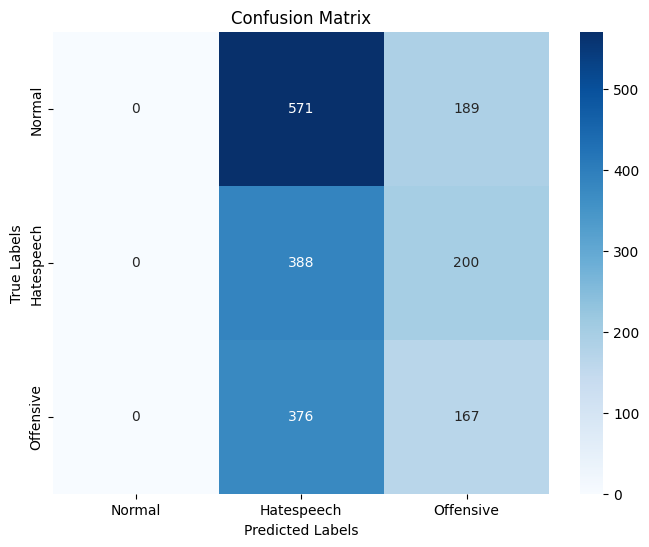

In [14]:
zsp.plot_confusion_matrix()

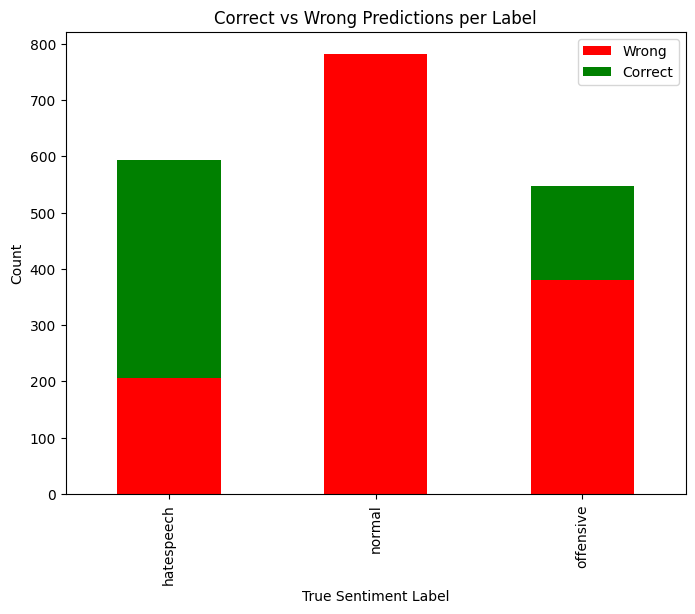

In [15]:
zsp.plot_correct_wrong()

In [16]:
tokenizer_sm, model_sm = zsp.model_params()

## Flan-T5 - Base Model

In [17]:
zsp = ZeroShotPrompting(model_name="google/flan-t5-base", output_dir=output_dir+"flan-t5-base-zero-shot", test_ds=test_ds)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [18]:
zsp.apply_prediction()

Processing Posts: 100%|██████████| 1924/1924 [02:47<00:00, 11.51it/s]


,post_text,true_label,predicted_label,match
0,i dont think im getting my baby them white 9 h...,normal,normal,True
1,laura loomer raped me while screaming at me in...,hatespeech,hatespeech,True
2,<user> what did the old lady do was she a nazi...,normal,normal,True
3,as much as i appreciate a format of open discu...,normal,normal,True
4,sex be so good a bitch be slow stroking and cr...,offensive,normal,False
...,...,...,...,...
1919,it always women trying this shit like dingbat ...,offensive,hatespeech,False
1920,because women would never lie about being sexu...,offensive,normal,False
1921,how is all that awesome muslim diversity going...,offensive,normal,False
1922,well my dear lgbtq brothers and sisters i do n...,hatespeech,normal,False


### Accuracy for Zero-Shot Prompting for [google/flan-t5-base](https://huggingface.co/google/flan-t5-base)

In [19]:
zsp.accuracy_score()

Accuracy: 50.47%


### f1-Score for Zero-Shot Prompting for [google/flan-t5-base](https://huggingface.co/google/flan-t5-base)

In [20]:
zsp.f1_score()

Macro F1 Score: 0.30


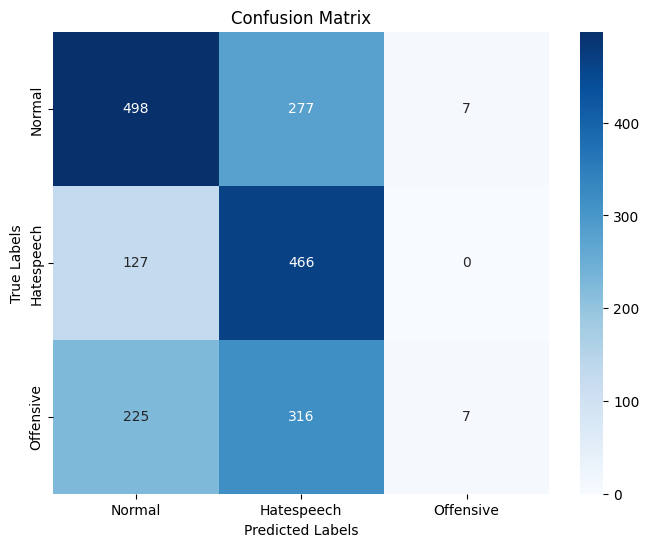

In [21]:
zsp.plot_confusion_matrix()

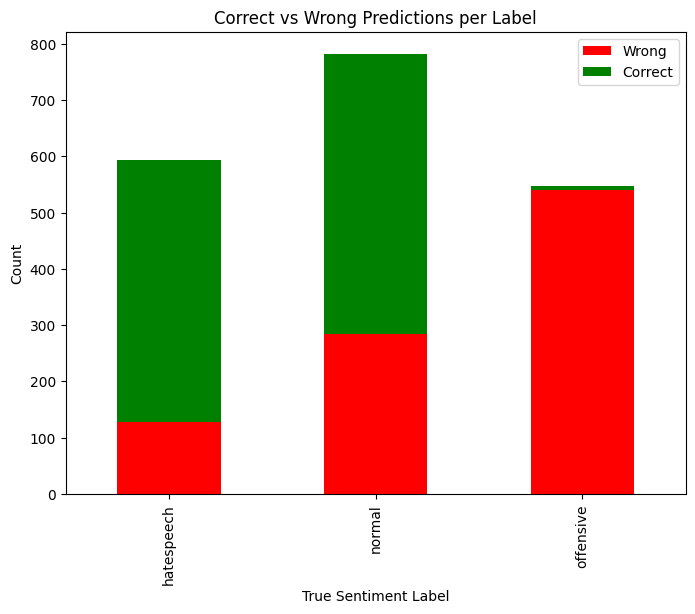

In [22]:
zsp.plot_correct_wrong()

In [23]:
tokenizer_bs, model_bs = zsp.model_params()

# Few-Shot Prompting for Hate-Speech Classification
## Flan-T5 - Small Model

In [24]:
# Combine the train and validation datasets using pd.concat
combined_ds = pd.concat([train_ds, valid_ds], ignore_index=True)

In [25]:
class FewShotPrompting:
    def __init__(self, tokenizer, model, output_dir, combined_ds, test_ds, k=5):
        self.output_dir = output_dir
        self.combined_ds = combined_ds
        self.test_ds = test_ds
        self.k = k
        self.index = None
        
        # Load the T5 model and tokenizer for predictions
        self.tokenizer = tokenizer
        self.model = model.to(device)  # Move model to device
        # Loading Sentence Encoding Model
        self.embed_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
        
        # Ensure output directory exists
        os.makedirs(self.output_dir, exist_ok=True)
    
    def create_embeddings(self):
        # Use self.embed_model to encode the entire post_text column at once
        self.embeddings = self.embed_model.encode(
            self.combined_ds['post_text'].tolist(), 
            convert_to_numpy=True, 
            show_progress_bar=True
        )
        self.create_faiss_index()
        
    def create_faiss_index(self):
        # Ensure the FAISS index is created properly
        d = self.embeddings.shape[1]  # Dimension of embeddings
        self.index = faiss.IndexFlatL2(d)  # Initialize the index
        self.index.add(self.embeddings)  # Add embeddings to FAISS index
        
    def retrieve_similar_examples(self, query):
        # Reshape query embedding to 2D (1, embedding_dim) for FAISS compatibility
        query_emb = self.embed_model.encode(
            query,
            show_progress_bar=False,
            convert_to_numpy=True
        ).reshape(1, -1)  # Reshape the query embedding

        D, I = self.index.search(query_emb, self.k)  # D: Distances, I: Indices
        return self.combined_ds.iloc[I[0]]

    def generate_prompt(self, post_text):
        similar_samples = self.retrieve_similar_examples(post_text)
        # Prepare examples in a more structured format
        samples = "\n\n".join(
            [f"\t\t**Statement**: {sample}\n\t\t**Label**: {label}" 
             for sample, label in zip(similar_samples['post_text'], similar_samples['sentiment_label'])]
        )
        prompt = f"""Classify the following statement into ONLY one of the three categories based on sentiment: normal, hatespeech, or offensive.
        
        Instructions:
        normal: Choose this category if the statement is neutral and does not incite any hate or offense. It should be an innocuous statement that does not target any group or individual.
           
        hatespeech: Choose this category if the statement explicitly targets a specific group of people with the intent to provoke hatred or cause harm. This includes derogatory comments based on religion, sexual orientation, ethnicity, or similar characteristics.
        
        offensive: Choose this category if the statement may be considered disrespectful or demeaning but does not explicitly incite violence or hatred. This includes statements that might hurt feelings or insult individuals/groups without crossing into hateful rhetoric.
        
        Use the below examples for refernce:\n\n
        {samples}
        
        Input: "{post_text}"
        Label:"""
        return prompt

    def predict(self, post_text):
        input_text = self.generate_prompt(post_text)
        input_ids = self.tokenizer(
            input_text, 
            return_tensors="pt",
            truncation=True,  # Truncate sequences longer than model's max length
            max_length=512  # Maximum length for the model
        ).input_ids.to(self.model.device)
        outputs = self.model.generate(input_ids)
        pred = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return pred.lower().strip()

    def apply_prediction(self):
        results = []
        for index, row in tqdm(self.test_ds.iterrows(), desc="Processing Posts", total=len(self.test_ds)):
            post_text = row['post_text']
            true_label = row['sentiment_label'].lower().strip()
            predicted_label = self.predict(post_text)
            match = true_label == predicted_label
            results.append({
                'post_text': post_text,
                'true_label': true_label,
                'predicted_label': predicted_label,
                'match': match
            })
        self.results_df = pd.DataFrame(results)
        results_file_path = os.path.join(self.output_dir, 'predictions_results.csv')
        self.results_df.to_csv(results_file_path, index=False)
        return self.results_df

    def accuracy_score(self):
        accuracy = accuracy_score(self.results_df['true_label'], self.results_df['predicted_label'])
        print(f"Accuracy: {accuracy * 100:.2f}%")

    def f1_score(self):
        f1 = f1_score(self.results_df['true_label'], self.results_df['predicted_label'], average='macro')
        print(f"Macro F1 Score: {f1:.2f}")

    def plot_confusion_matrix(self):
        cm = confusion_matrix(self.results_df['true_label'], self.results_df['predicted_label'], 
                              labels=['normal', 'hatespeech', 'offensive'])
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Normal', 'Hatespeech', 'Offensive'], 
                    yticklabels=['Normal', 'Hatespeech', 'Offensive'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.savefig(os.path.join(self.output_dir, 'confusion_matrix.png'))
        plt.show()

    def plot_correct_wrong(self):
        correct_wrong_summary = self.results_df.groupby(['true_label', 'match']).size().unstack(fill_value=0)
        correct_wrong_summary.plot(kind='bar', stacked=True, color=['red', 'green'], figsize=(8, 6))
        plt.title('Correct vs Wrong Predictions per Label')
        plt.xlabel('True Sentiment Label')
        plt.ylabel('Count')
        plt.legend(['Wrong', 'Correct'])
        plt.savefig(os.path.join(self.output_dir, 'correct_wrong_predictions.png'))
        plt.show()


In [26]:
fsp = FewShotPrompting(tokenizer_sm, model_sm, output_dir+"flan-t5-sm-few-shot", combined_ds, test_ds)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [27]:
fsp.create_embeddings()

Batches:   0%|          | 0/541 [00:00<?, ?it/s]

In [28]:
fsp.apply_prediction()

Processing Posts: 100%|██████████| 1924/1924 [02:31<00:00, 12.71it/s]


,post_text,true_label,predicted_label,match
0,i dont think im getting my baby them white 9 h...,normal,hatespeech,False
1,laura loomer raped me while screaming at me in...,hatespeech,hatespeech,True
2,<user> what did the old lady do was she a nazi...,normal,hatespeech,False
3,as much as i appreciate a format of open discu...,normal,hatespeech,False
4,sex be so good a bitch be slow stroking and cr...,offensive,offensive,True
...,...,...,...,...
1919,it always women trying this shit like dingbat ...,offensive,hatespeech,False
1920,because women would never lie about being sexu...,offensive,hatespeech,False
1921,how is all that awesome muslim diversity going...,offensive,hatespeech,False
1922,well my dear lgbtq brothers and sisters i do n...,hatespeech,hatespeech,True


### Accuracy for Few-Shot Prompting for [google/flan-t5-small](https://huggingface.co/google/flan-t5-small)

In [29]:
fsp.accuracy_score()

Accuracy: 33.63%


### f1-Score for Few-Shot Prompting for [google/flan-t5-small](https://huggingface.co/google/flan-t5-small)

In [30]:
fsp.f1_score()

Macro F1 Score: 0.14


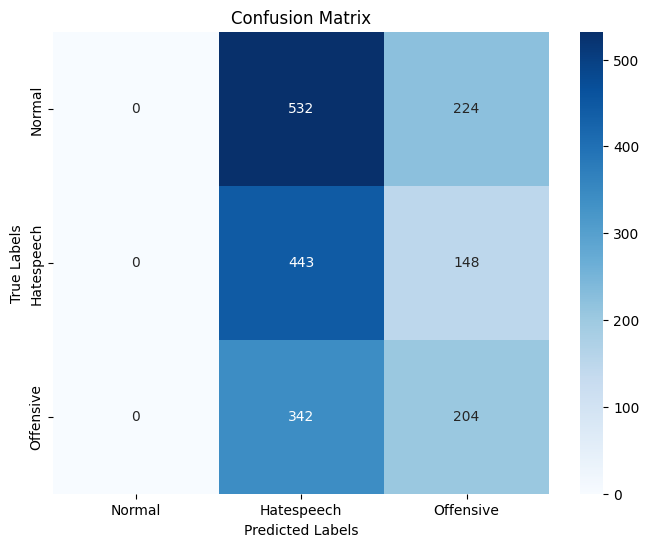

In [31]:
fsp.plot_confusion_matrix()

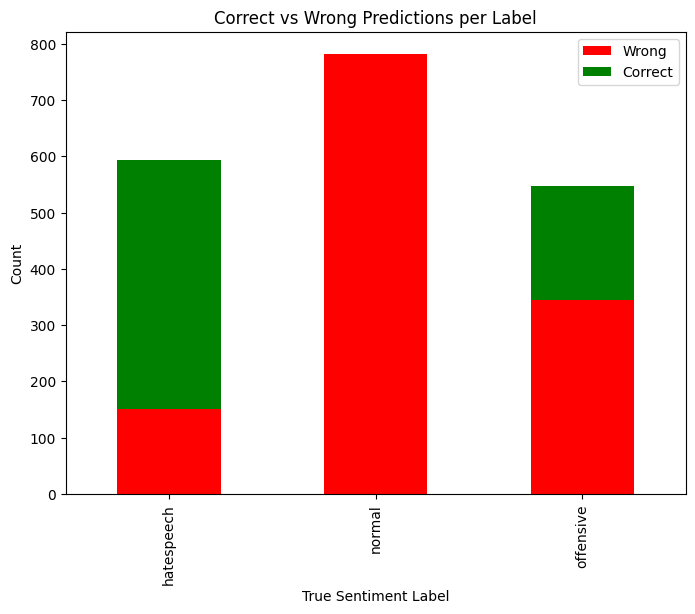

In [32]:
fsp.plot_correct_wrong()

## Flan-T5 - Base Model

In [33]:
fsp = FewShotPrompting(tokenizer_bs, model_bs, output_dir+"flan-t5-base-few-shot", combined_ds, test_ds, k=7)

In [34]:
fsp.create_embeddings()

Batches:   0%|          | 0/541 [00:00<?, ?it/s]

In [35]:
fsp.apply_prediction()

Processing Posts: 100%|██████████| 1924/1924 [03:00<00:00, 10.68it/s]


,post_text,true_label,predicted_label,match
0,i dont think im getting my baby them white 9 h...,normal,normal,True
1,laura loomer raped me while screaming at me in...,hatespeech,normal,False
2,<user> what did the old lady do was she a nazi...,normal,normal,True
3,as much as i appreciate a format of open discu...,normal,normal,True
4,sex be so good a bitch be slow stroking and cr...,offensive,normal,False
...,...,...,...,...
1919,it always women trying this shit like dingbat ...,offensive,hatespeech,False
1920,because women would never lie about being sexu...,offensive,normal,False
1921,how is all that awesome muslim diversity going...,offensive,normal,False
1922,well my dear lgbtq brothers and sisters i do n...,hatespeech,normal,False


### Accuracy for Few-Shot Prompting for [google/flan-t5-base](https://huggingface.co/google/flan-t5-base)

In [36]:
fsp.accuracy_score()

Accuracy: 48.54%


### f1-Score for Few-Shot Prompting for [google/flan-t5-base](https://huggingface.co/google/flan-t5-base)

In [37]:
fsp.f1_score()

Macro F1 Score: 0.39


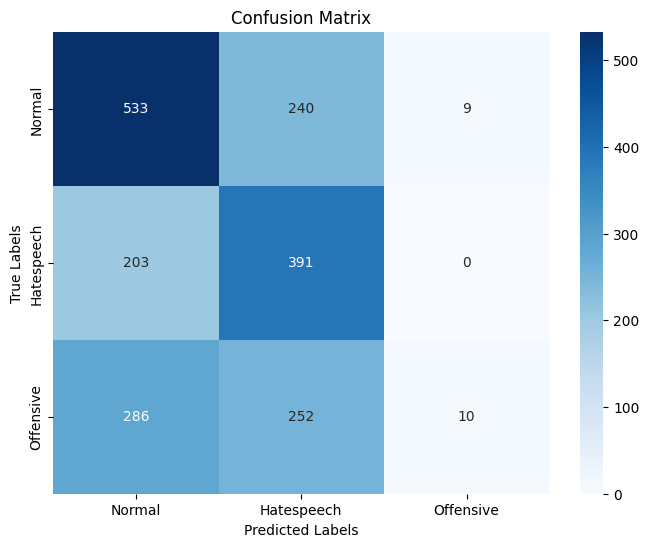

In [38]:
fsp.plot_confusion_matrix()

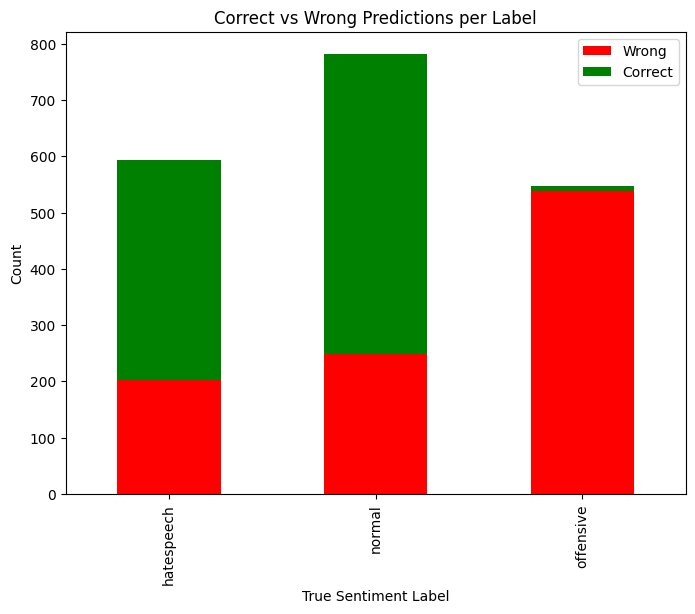

In [39]:
fsp.plot_correct_wrong()